In [2]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
sys.path.insert(0, '/Users/weilu/Research/opt_server/')
from pyCodeLib import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
def get_res_by_globalindex(res_list, index, chain):
    # the res has to be on the same chain as "chain"
    if index < 0:
        return -1
    try:
        res = res_list[index]
    except:
        return -1
    if res.get_parent().get_id() == chain:
        return res
    else:
        return -1
    
def get_gxxxg_anti_parallel_data(fileLocation, get_distance_between_two_residues):
    structure = parse_pdb(fileLocation)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    sequence = get_sequence_from_structure(structure)
    
    # database survey on the distribution of GXXXG pairs.
    # focus on anti parallel first. (means i to j+4, i+4 to j)
    min_seq_sep = 10
    r_max = 9.5
    info_list = []
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            if res2globalindex - res1globalindex >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                res1type = get_res_type(res_list, res1)
                res2type = get_res_type(res_list, res2)
                rij = get_distance_between_two_residues(res1, res2)
                res1_2_globalindex = res1globalindex+4
                res2_2_globalindex = res2globalindex-4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res1chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                rij_2 = get_distance_between_two_residues(res1_2, res2_2)
                if rij_2 > 9.5:
                    continue
                info_ = [res1globalindex, res1.resname, res2globalindex, res2.resname, res1_2_globalindex, res1_2.resname, res2_2_globalindex, res2_2.resname, rij, rij_2]
                info_list.append(info_)
                # print(info_)

    data = pd.DataFrame(info_list, columns=["Index1_1", "Res1_1", "Index2_1", "Res2_1", "Index1_2", "Res1_2", "Index2_2", "Res2_2", "rij", "rij_2"])
    return data

In [106]:
# (G)(CAST)(P)(IMLV)(NHQEDRK)(FYW)
six_letter_code_letters = {
    'I':3,
    'M':3,
    'L':3,
    'V':3,
    'F':5,
    'Y':5,
    'W':5,
    'G':0,
    'P':2,
    'C':1,
    'A':1,
    'S':1,
    'T':1,
    'N':4,
    'H':4,
    'Q':4,
    'E':4,
    'D':4,
    'R':4,
    'K':4
}


pair_index_lookup = {}
rev_pair_index_lookup = {}
n = 6
count = 0
for i in range(n):
    for j in range(n):
        pair_index_lookup[f"{i}_{j}"] = count
        rev_pair_index_lookup[count] = f"{i}_{j}"
        count += 1
        
pair_n = 36
count = 0
look_up_table = {}
rev_look_up_table = {}
for ii in range(pair_n):
    for jj in range(ii+1):
        look_up_table[f"{ii}_{jj}"] = count
        look_up_table[f"{jj}_{ii}"] = count
        rev_look_up_table[count] = [rev_pair_index_lookup[ii]+"_"+rev_pair_index_lookup[jj]]
        count += 1

def get_interaction_index(data, six_letter_code_letters=six_letter_code_letters, 
                          pair_index_lookup=pair_index_lookup,
                          look_up_table=look_up_table):
    Res1_1 = data["Res1_1"]
    Res2_1 = data["Res2_1"]
    Res1_2 = data["Res1_2"]
    Res2_2 = data["Res2_2"]
    i1 = six_letter_code_letters[three_to_one(Res1_1)]
    i2 = six_letter_code_letters[three_to_one(Res1_2)]
    j1 = six_letter_code_letters[three_to_one(Res2_1)]
    j2 = six_letter_code_letters[three_to_one(Res2_2)]
    ii = all_combination[f"{i1}_{i2}"]
    jj = all_combination[f"{j1}_{j2}"]
    return look_up_table[f"{ii}_{jj}"]

In [4]:
import glob
pdb_list = glob.glob("/Users/weilu/Research/server/jun_week4_2020/alpha_helical_membrane_protein/cleaned_pdbs/*.pdb")
pdb_list = [os.path.basename(a)[:-4] for a in pdb_list]

In [169]:
import glob
pdb_list = glob.glob("/Users/weilu/Research/server/jun_week4_2020/alpha_helical_membrane_protein/membrane_part_only/*.pdb")
pdb_list = [os.path.basename(a)[:-4] for a in pdb_list]

In [173]:
pd.DataFrame(pdb_list, columns=["Protein"]).to_csv("/Users/weilu/Research/database/gxxxg_protein_list.csv")

In [ ]:
pd.read_csv("/Users/weilu/Research/database/gxxxg_protein_list.csv", index_col=0)

In [170]:
len(pdb_list)

4165

In [9]:
pdb_list = glob.glob("/Users/weilu/Research/server/jun_week4_2020/alpha_helical_membrane_protein/interaction_info/*.csv")
pdb_list = [os.path.basename(a)[:-4] for a in pdb_list]
d_list = []
for i, pdb in enumerate(pdb_list[:10]):
    if i % 100 == 0:
        print(i, pdb)
    a = pd.read_csv(f"/Users/weilu/Research/server/jun_week4_2020/alpha_helical_membrane_protein/interaction_info/{pdb}.csv", index_col=0)
    if len(a) == 0:
        continue
    d_list.append(a.assign(Protein=pdb))
d = pd.concat(d_list).reset_index(drop=True)
d.to_csv("info_interaction.csv")

In [60]:
20*21/2

210.0

In [61]:
36*37/2

666.0

In [ ]:
data = pd.read_csv("/Users/weilu/Research/server/jun_week4_2020/alpha_helical_membrane_protein/info_interaction.csv", index_col=0)

In [177]:
data.shape

(4405818, 11)

In [40]:
data_cutoff = data.query("rij < 6.5 and rij_2 < 6.5").reset_index()

In [41]:
data_cutoff.shape

(409608, 12)

In [184]:
t = data_cutoff["Protein"].value_counts().reset_index()

In [206]:
t.to_csv("/Users/weilu/Research/database/gxxxg_count.csv")

In [220]:
t = pd.read_csv("/Users/weilu/Research/database/gxxxg_count.csv", index_col=0)
tt = t.query("Protein > 5")["index"].to_list()

In [221]:
t.shape

(4081, 2)

In [203]:
tt = t.query("Protein > 5")["index"].to_list()

In [204]:
len(tt)

4049

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d2c1320>]],
      dtype=object)

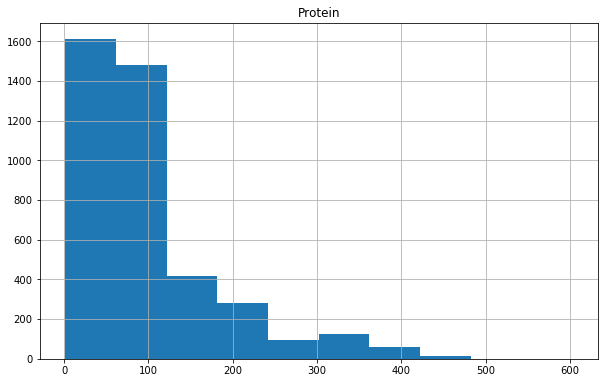

In [185]:
t.hist("Protein")

# using 6 letter code

In [98]:
data_cutoff["interaction"] = data_cutoff.apply(get_interaction_index, axis=1)

In [108]:
t = data_cutoff["interaction"].value_counts().reset_index()

## using simplified code,(6 letter code)
I think, there is a bit too crowded near index 250.

In [114]:
t.head(400)

,index,interaction
0,250,14598
1,252,14146
2,240,12724
3,199,12411
4,238,9457
...,...,...
395,547,105
396,55,104
397,258,101
398,441,101


In [111]:
data_cutoff["interaction"].unique().shape

(636,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136859320>]],
      dtype=object)

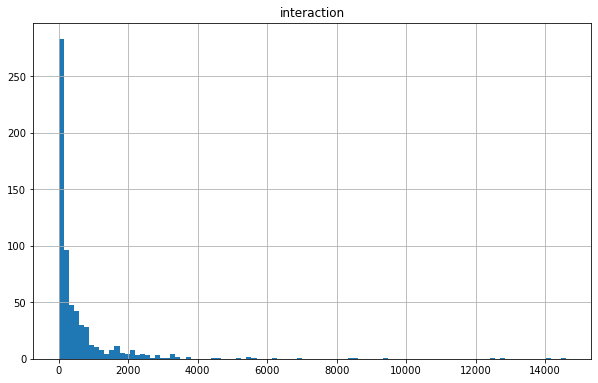

In [110]:
t.hist("interaction", bins=100)

In [107]:
rev_look_up_table[250]

['3_3_3_1']

### How many satisfy the condition
Among 400*400 = 160,000 possible combination.
Four body interaction exist in 26235 pair exists.

In [116]:
b = data_cutoff.groupby(["Res1_1", "Res2_1", "Res1_2", "Res2_2"])["rij"].count().reset_index().sort_values("rij")

In [117]:
b.shape

(26235, 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d51b208>]],
      dtype=object)

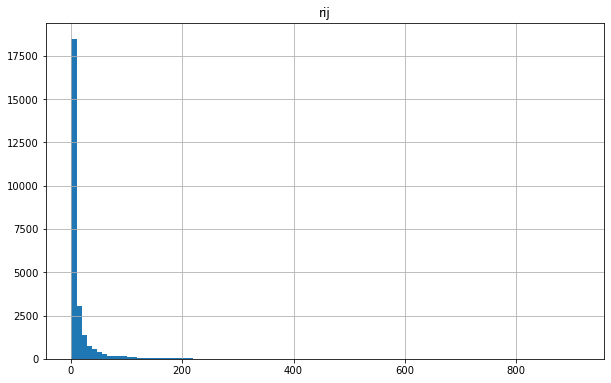

In [119]:
b.hist("rij", bins=100)

In [121]:
b.query("rij > 10").shape

(7747, 5)

In [122]:
b.query("rij > 100").shape

(747, 5)

In [123]:
b.query("rij > 100")

,Res1_1,Res2_1,Res1_2,Res2_2,rij
18493,SER,ASN,MET,GLY,101
24920,VAL,LEU,ALA,ALA,101
18750,SER,GLY,ALA,THR,101
24527,VAL,GLY,ALA,THR,101
7517,GLY,SER,THR,VAL,101
...,...,...,...,...,...
1168,ALA,LEU,MET,ALA,578
10063,ILE,THR,ALA,LEU,593
11830,LEU,LEU,LEU,LEU,652
22440,TRP,PRO,TRP,ARG,771


In [128]:
# reduce the redundant
from Bio.PDB.Polypeptide import three_to_index
from Bio.PDB.Polypeptide import index_to_three

In [130]:
b_cutoff = b.query("rij > 100").reset_index(drop=True)

In [168]:
def get_interaction_index_from_four_residues(Res1_1, Res1_2, Res2_1, Res2_2):
    i1 = three_to_index(Res1_1)
    i2 = three_to_index(Res1_2)
    j1 = three_to_index(Res2_1)
    j2 = three_to_index(Res2_2)
    ii = i1 * 20 + i2
    jj = j1 * 20 + j2
    if ii > jj:
        return f"{ii}_{jj}"
    else:
        return f"{jj}_{ii}"
def get_interaction_index(data):
    Res1_1 = data["Res1_1"]
    Res2_1 = data["Res2_1"]
    Res1_2 = data["Res1_2"]
    Res2_2 = data["Res2_2"]
    get_interaction_index_from_four_residues(Res1_1, Res1_2, Res2_1, Res2_2)

In [135]:
b_cutoff["interaction_index"] = b_cutoff.apply(get_interaction_index, axis=1)

In [138]:
b_cutoff["interaction_index"].unique().shape

(700,)

In [140]:
for res in ["Res1_1", "Res2_1", "Res1_2", "Res2_2"]:
    print(res, b_cutoff[res].unique().shape)

Res1_1 (20,)
Res2_1 (20,)
Res1_2 (20,)
Res2_2 (20,)


In [146]:
b_cutoff_unique = b_cutoff.groupby("interaction_index").tail(1)
b_cutoff_unique = b_cutoff_unique.reset_index(drop=True)

In [147]:
b_cutoff_unique

,Res1_1,Res2_1,Res1_2,Res2_2,rij,interaction_index
0,SER,ASN,MET,GLY,101,310_225
2,SER,GLY,ALA,THR,101,300_116
3,VAL,GLY,ALA,THR,101,340_116
4,GLY,SER,THR,VAL,101,317_116
5,ALA,HIS,THR,VAL,101,137_16
...,...,...,...,...,...,...
742,ALA,LEU,MET,ALA,578,180_10
743,ILE,THR,ALA,LEU,593,329_140
744,LEU,LEU,LEU,LEU,652,189_189
745,TRP,PRO,TRP,ARG,771,378_254


In [166]:
def get_interaction_index_from_four_residues(Res1_1, Res1_2, Res2_1, Res2_2):
    i1 = three_to_index(Res1_1)
    i2 = three_to_index(Res1_2)
    j1 = three_to_index(Res2_1)
    j2 = three_to_index(Res2_2)
    ii = i1 * 20 + i2
    jj = j1 * 20 + j2
    if ii > jj:
        return f"{ii}_{jj}"
    else:
        return f"{jj}_{ii}"
    
b_cutoff_unique = pd.read_csv("/Users/weilu/Research/database/interaction_index.csv", index_col=0)
interaction_index_dic = {}
for i, index in enumerate(b_cutoff_unique["interaction_index"]):
    interaction_index_dic[index] = i

In [163]:
b_cutoff_unique.to_csv("/Users/weilu/Research/database/interaction_index.csv")

In [ ]:
def phi_gxxxg_well(res_list, neighbor_list, parameter_list):
    # focus on anti parallel first. (means i to j+4, i+4 to j)
    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    kappa = 5
    n_parameters = 701
    info_list = []
    phi_gxxxg_well = np.zeros(n_parameters)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            if res2globalindex - res1globalindex >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                res1type = get_res_type(res_list, res1)
                res2type = get_res_type(res_list, res2)
                rij = get_distance_between_two_residues(res1, res2)
                res1_2_globalindex = res1globalindex+4
                res2_2_globalindex = res2globalindex-4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res1chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                rij_2 = get_distance_between_two_residues(res1_2, res2_2)
                if rij_2 > (r_max+2):
                    continue
                info_ = [res1globalindex, res1.resname, res2globalindex, res2.resname, res1_2_globalindex, res1_2.resname, res2_2_globalindex, res2_2.resname, rij, rij_2]
                info_list.append(info_)
                
                interaction_index = get_interaction_index_from_four_residues(res1.resname, res1_2.resname, res2.resname, res2_2.resname)
                phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                try:
                    index = interaction_index_dic[interaction_index]
                    phi_gxxxg_well[index] += phi_
                except:
                    phi_gxxxg_well[-1] += phi_
                # print(info_)
    phis_to_return = []
    for i in range(n_parameters):
        phis_to_return.append(round(phi_gxxxg_well[i],4))
    return phis_to_return


In [ ]:
def get_gxxxg_anti_parallel_data(fileLocation, get_distance_between_two_residues):
    structure = parse_pdb(fileLocation)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    sequence = get_sequence_from_structure(structure)
    
    # database survey on the distribution of GXXXG pairs.
    # focus on anti parallel first. (means i to j+4, i+4 to j)
    min_seq_sep = 10
    r_max = 9.5
    info_list = []
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            if res2globalindex - res1globalindex >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                res1type = get_res_type(res_list, res1)
                res2type = get_res_type(res_list, res2)
                rij = get_distance_between_two_residues(res1, res2)
                res1_2_globalindex = res1globalindex+4
                res2_2_globalindex = res2globalindex-4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res1chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                rij_2 = get_distance_between_two_residues(res1_2, res2_2)
                if rij_2 > 9.5:
                    continue
                info_ = [res1globalindex, res1.resname, res2globalindex, res2.resname, res1_2_globalindex, res1_2.resname, res2_2_globalindex, res2_2.resname, rij, rij_2]
                info_list.append(info_)
                # print(info_)

    data = pd.DataFrame(info_list, columns=["Index1_1", "Res1_1", "Index2_1", "Res2_1", "Index1_2", "Res1_2", "Index2_2", "Res2_2", "rij", "rij_2"])
    return data

In [129]:
for i in range(20):
    print(index_to_three(i))

ALA
CYS
ASP
GLU
PHE
GLY
HIS
ILE
LYS
LEU
MET
ASN
PRO
GLN
ARG
SER
THR
VAL
TRP
TYR


In [127]:
three_to_index("ALA")

0

In [63]:
data_cutoff.query("Res1_1=='PHE' and Res2_1=='PHE' and Res1_2=='ALA' and Res2_2=='PHE'")

,index,Index1_1,Res1_1,Index2_1,Res2_1,Index1_2,Res1_2,Index2_2,Res2_2,rij,rij_2,Protein
596,6245,67,PHE,89,PHE,71,ALA,85,PHE,5.130413,5.344700,4lmj
615,6415,171,PHE,192,PHE,175,ALA,188,PHE,5.133391,5.359655,4lmj
633,6589,273,PHE,295,PHE,277,ALA,291,PHE,5.133659,5.293667,4lmj
651,6762,376,PHE,398,PHE,380,ALA,394,PHE,5.163421,5.360066,4lmj
671,6936,481,PHE,503,PHE,485,ALA,499,PHE,5.139779,5.347360,4lmj
...,...,...,...,...,...,...,...,...,...,...,...,...
397046,4269123,157,PHE,183,PHE,161,ALA,179,PHE,5.038108,5.086150,4cof
397070,4269324,255,PHE,281,PHE,259,ALA,277,PHE,5.057173,5.097425,4cof
397095,4269527,353,PHE,379,PHE,357,ALA,375,PHE,4.856940,5.112073,4cof
397119,4269734,452,PHE,478,PHE,456,ALA,474,PHE,5.036300,5.065147,4cof


In [65]:
data_cutoff.query("Res1_1=='GLY' and Res2_1=='GLY' and Res1_2=='GLY' and Res2_2=='GLY'").sample(10)

,index,Index1_1,Res1_1,Index2_1,Res2_1,Index1_2,Res1_2,Index2_2,Res2_2,rij,rij_2,Protein
357884,3855309,296,GLY,318,GLY,300,GLY,314,GLY,3.026064,4.078103,3mkt
76654,837376,453,GLY,498,GLY,457,GLY,494,GLY,5.641916,4.720324,6h2f
76585,836665,118,GLY,164,GLY,122,GLY,160,GLY,5.507015,4.735941,6h2f
16862,180586,112,GLY,129,GLY,116,GLY,125,GLY,4.992289,4.841475,4kjp
268735,2907902,901,GLY,931,GLY,905,GLY,927,GLY,4.849750,5.640655,4hyg
260327,2817418,208,GLY,236,GLY,212,GLY,232,GLY,5.291325,4.608969,3c1i
198885,2155416,487,GLY,507,GLY,491,GLY,503,GLY,4.856650,4.930821,4kk5
76643,837255,396,GLY,441,GLY,400,GLY,437,GLY,5.649156,5.112854,6h2f
272095,2941635,488,GLY,505,GLY,492,GLY,501,GLY,5.217060,5.052255,4kjq
226800,2457017,280,GLY,294,GLY,284,GLY,290,GLY,4.506031,5.561304,5xjj


In [51]:
b.query("rij > 100")["rij"].sum()

135981

In [49]:
for res in ["Res1_1", "Res2_1", "Res1_2", "Res2_2"]:
    print(res, b[res].unique().shape)

Res1_1 (20,)
Res2_1 (20,)
Res1_2 (20,)
Res2_2 (20,)


In [53]:
b.query("Res1_1=='GLY' and Res1_2=='GLY'")

,Res1_1,Res2_1,Res1_2,Res2_2,rij
7457,GLY,SER,GLY,TYR,1
7452,GLY,SER,GLY,MET,1
7578,GLY,THR,GLY,ARG,1
7450,GLY,SER,GLY,ILE,1
7249,GLY,PHE,GLY,SER,1
...,...,...,...,...,...
6671,GLY,GLY,GLY,VAL,136
6664,GLY,GLY,GLY,LEU,144
6242,GLY,ALA,GLY,ALA,165
6972,GLY,LEU,GLY,GLY,172


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13b5e5f28>]],
      dtype=object)

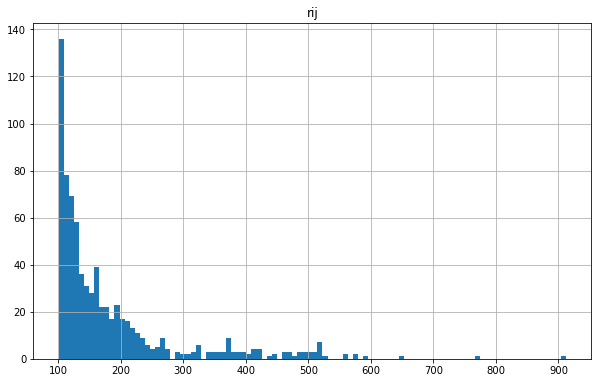

In [54]:
b.query("rij > 100").hist("rij", bins=100)

In [28]:
a = data.groupby(["Res1_1", "Res2_1", "Res1_2", "Res2_2"])["rij"].count().reset_index().sort_values("rij")

In [32]:
a.shape

(101863, 5)

In [34]:
a.query("rij > 100").shape

(10583, 5)

In [35]:
a.query("rij > 1000").shape

(178, 5)

In [36]:
a.query("rij > 1000")

,Res1_1,Res2_1,Res1_2,Res2_2,rij
30717,GLY,ALA,ILE,ILE,1001
50243,LEU,LEU,LEU,TYR,1002
101627,VAL,VAL,GLY,VAL,1002
43431,ILE,LEU,LEU,ALA,1004
36704,GLY,VAL,LEU,LEU,1006
...,...,...,...,...,...
3509,ALA,LEU,VAL,ALA,2034
50036,LEU,LEU,ALA,LEU,2072
50244,LEU,LEU,LEU,VAL,2160
0,ALA,ALA,ALA,ALA,2428


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13b9477b8>]],
      dtype=object)

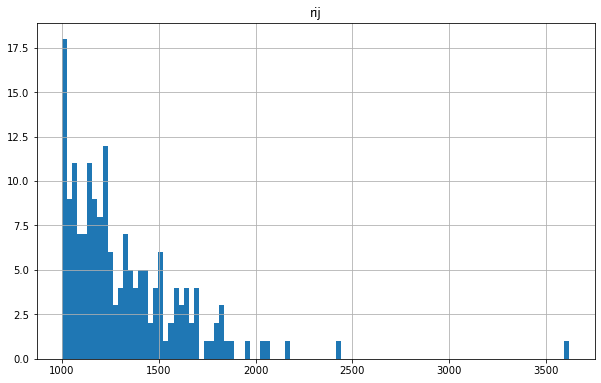

In [37]:
a.query("rij > 1000").hist("rij", bins=100)

In [67]:
# (G)(CAST)(P)(IMLV)(NHQEDRK)(FYW)
six_letter_code_letters = {
    'I':3,
    'M':3,
    'L':3,
    'V':3,
    'F':5,
    'Y':5,
    'W':5,
    'G':0,
    'P':2,
    'C':1,
    'A':1,
    'S':1,
    'T':1,
    'N':4,
    'H':4,
    'Q':4,
    'E':4,
    'D':4,
    'R':4,
    'K':4
}

pair_index_lookup = {}
n = 6
count = 0
for i in range(n):
    for j in range(n):
        pair_index_lookup[f"{i}_{j}"] = count
        count += 1
        
pair_n = 36
count = 0
look_up_table = {}
for ii in range(pair_n):
    for jj in range(ii+1):
        look_up_table[f"{ii}_{jj}"] = count
        look_up_table[f"{jj}_{ii}"] = count
        count += 1
        
def get_interaction_index(data, six_letter_code_letters=six_letter_code_letters, 
                          pair_index_lookup=pair_index_lookup,
                          look_up_table=look_up_table):
    Res1_1 = data["Res1_1"]
    Res2_1 = data["Res2_1"]
    Res1_2 = data["Res1_2"]
    Res2_2 = data["Res2_2"]
    i1 = six_letter_code_letters[three_to_one(Res1_1)]
    i2 = six_letter_code_letters[three_to_one(Res1_2)]
    j1 = six_letter_code_letters[three_to_one(Res2_1)]
    j2 = six_letter_code_letters[three_to_one(Res2_2)]
    ii = all_combination[f"{i1}_{i2}"]
    jj = all_combination[f"{j1}_{j2}"]
    return look_up_table[f"{ii}_{jj}"]

20

In [94]:
tiny.apply(get_interaction_index, axis=1)

0      657
1      503
2       52
3      193
4      209
      ... 
995    579
996    283
997    234
998    262
999    254
Length: 1000, dtype: int64

In [22]:
tiny = data.sample(1000).reset_index(drop=True)

In [26]:
tiny.groupby(["Res1_1", "Res2_1", "Res1_2", "Res2_2"])["rij"].count().reset_index().sort_values("rij")

,Res1_1,Res2_1,Res1_2,Res2_2,rij
0,ALA,ALA,ALA,ALA,1
630,PHE,MET,SER,GLY,1
631,PHE,MET,VAL,GLY,1
632,PHE,PHE,ALA,GLN,1
633,PHE,PHE,ALA,PHE,1
...,...,...,...,...,...
898,VAL,GLY,VAL,GLY,2
911,VAL,LEU,ALA,ALA,2
104,ALA,TYR,LEU,LEU,2
202,GLY,ALA,VAL,LEU,3


In [10]:
len(pdb_list)

4159

In [7]:
a = pd.read_csv("/Users/weilu/Research/server/jun_week4_2020/alpha_helical_membrane_protein/interaction_info/6uks.csv")

In [8]:
len(a)

0

In [ ]:
get_distance_between_two_residues = get_interaction_distance_com
d_list = []
for i, pdb in enumerate(pdb_list):
    if i % 100 == 0:
        print(i, pdb)
    fileLocation = f"/Users/weilu/Research/server/jun_week4_2020/alpha_helical_membrane_protein/membrane_part_only/{pdb}"
    # get_distance_between_two_residues = get_interaction_distance
    try:
        d_ = get_gxxxg_anti_parallel_data(fileLocation, get_distance_between_two_residues)
        d_list.append(d_.assign(Protein=pdb))
    except:
        print(pdb)

In [32]:
p_data = pd.read_csv("/Users/weilu/Research/server/jun_week4_2020/gxxxg_shuffle_optimization/has_structures_small_dataset_cleaned.csv")

In [47]:
pdb_list = p_data["Protein"].values

In [58]:
get_distance_between_two_residues = get_interaction_distance_com
d_list = []
for pdb in pdb_list:
    fileLocation = f"/Users/weilu/Research/server/jun_week4_2020/cath_dataset_shuffle_optimization/database/dompdb/{pdb}"
    # get_distance_between_two_residues = get_interaction_distance
    d_ = get_gxxxg_anti_parallel_data(fileLocation, get_distance_between_two_residues)
    d_list.append(d_.assign(Protein=pdb))

In [59]:
data = pd.concat(d_list).reset_index(drop=True)

In [67]:
a = data.groupby(["Res1_1", "Res2_1", "Res1_2", "Res2_2"])["rij"].count().reset_index()
a

,Res1_1,Res2_1,Res1_2,Res2_2,rij
0,ALA,ALA,ALA,ALA,44
1,ALA,ALA,ALA,ARG,4
2,ALA,ALA,ALA,ASN,4
3,ALA,ALA,ALA,ASP,15
4,ALA,ALA,ALA,CYS,4
...,...,...,...,...,...
66329,VAL,VAL,VAL,SER,3
66330,VAL,VAL,VAL,THR,2
66331,VAL,VAL,VAL,TRP,2
66332,VAL,VAL,VAL,TYR,6


In [68]:
a.sort_values("rij")

,Res1_1,Res2_1,Res1_2,Res2_2,rij
32580,ILE,VAL,LYS,LYS,1
26865,HIS,GLY,TYR,GLN,1
26866,HIS,GLY,TYR,ILE,1
26867,HIS,GLY,TYR,LEU,1
51091,SER,CYS,THR,PHE,1
...,...,...,...,...,...
64280,VAL,LEU,LEU,LEU,68
35715,LEU,LEU,LEU,ILE,70
30532,ILE,LEU,LEU,LEU,70
35725,LEU,LEU,LEU,VAL,76


In [75]:
a.query("Res1_1 =='GLY'").sort_values("rij")

,Res1_1,Res2_1,Res1_2,Res2_2,rij
25407,GLY,THR,GLU,GLU,1
23962,GLY,HIS,GLU,PHE,1
23961,GLY,HIS,GLU,LYS,1
23960,GLY,HIS,GLU,GLN,1
23959,GLY,HIS,GLU,ARG,1
...,...,...,...,...,...
25922,GLY,VAL,LEU,LEU,14
24437,GLY,LEU,LEU,ILE,15
24153,GLY,ILE,LEU,LEU,16
24447,GLY,LEU,LEU,VAL,17


In [73]:
a.query("rij > 40")

,Res1_1,Res2_1,Res1_2,Res2_2,rij
0,ALA,ALA,ALA,ALA,44
2380,ALA,LEU,ALA,ALA,41
2390,ALA,LEU,ALA,LEU,46
2569,ALA,LEU,LEU,LEU,66
6779,ARG,LEU,LEU,LEU,46
20779,GLU,LEU,LEU,LEU,42
30211,ILE,ILE,LEU,LEU,45
30353,ILE,LEU,ALA,LEU,42
30532,ILE,LEU,LEU,LEU,70
30541,ILE,LEU,LEU,VAL,47


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12476c2e8>]],
      dtype=object)

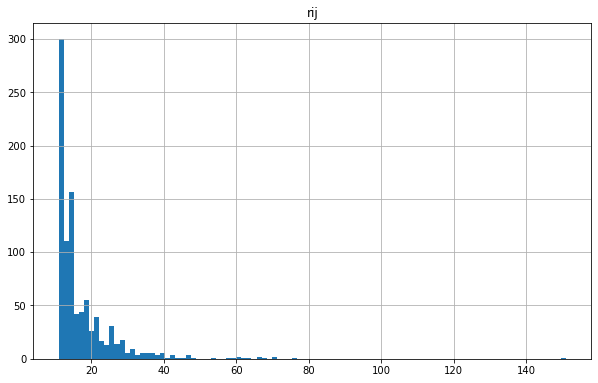

In [72]:
a.query("rij > 10").hist("rij", bins=100)

In [60]:
selected = data.query("a")

,Index1_1,Res1_1,Index2_1,Res2_1,Index1_2,Res1_2,Index2_2,Res2_2,rij,rij_2,Protein
0,0,ASN,30,TRP,4,ALA,26,LEU,9.896258,4.324449,3b89A01
1,0,ASN,27,THR,4,ALA,23,ARG,11.182194,9.386137,3b89A01
2,0,ASN,26,LEU,4,ALA,22,VAL,9.695612,7.971409,3b89A01
3,1,ILE,23,ARG,5,LEU,19,PRO,5.874432,6.003531,3b89A01
4,1,ILE,30,TRP,5,LEU,26,LEU,7.363230,6.706841,3b89A01
...,...,...,...,...,...,...,...,...,...,...,...
142717,136,SER,147,LEU,140,ASP,143,ILE,10.032258,7.372383,2f6sA00
142718,150,HIS,164,GLY,154,ASN,160,THR,11.588511,5.193906,2f6sA00
142719,150,HIS,160,THR,154,ASN,156,ASN,12.843557,7.583080,2f6sA00
142720,152,SER,162,ILE,156,ASN,158,PRO,14.189913,7.998445,2f6sA00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12605a208>]],
      dtype=object)

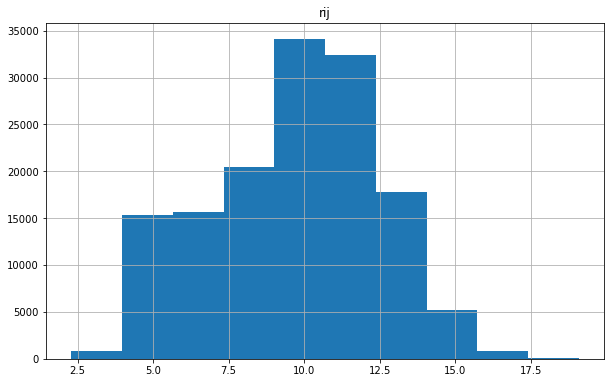

In [61]:
data.hist("rij")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126017128>]],
      dtype=object)

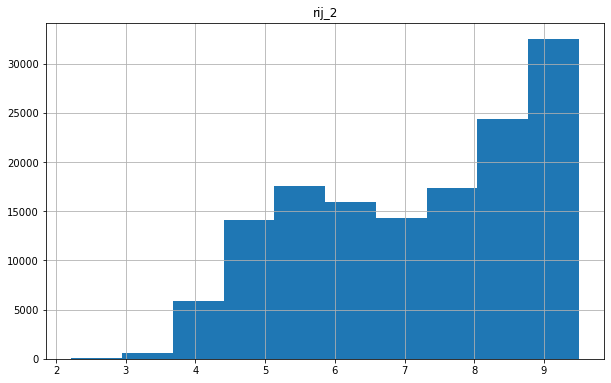

In [62]:
data.hist("rij_2")

## hello

In [ ]:
data.

In [44]:
fileLocation = "/Users/weilu/Research/server/jun_week4_2020/cath_dataset_shuffle_optimization/database/dompdb/2ltuA00"
# get_distance_between_two_residues = get_interaction_distance
get_distance_between_two_residues = get_interaction_distance_com
get_gxxxg_anti_parallel_data(fileLocation, get_distance_between_two_residues)

,Index1_1,Res1_1,Index2_1,Res2_1,Index1_2,Res1_2,Index2_2,Res2_2,rij,rij_2
0,3,MET,34,TYR,7,ALA,30,MET,5.490308,6.103602
1,5,TYR,15,VAL,9,VAL,11,ASP,13.919746,9.252665
2,5,TYR,38,PRO,9,VAL,34,TYR,8.890673,9.190235
3,6,ASP,33,LEU,10,ILE,29,VAL,12.986689,8.094069
4,6,ASP,34,TYR,10,ILE,30,MET,7.405823,5.190758
...,...,...,...,...,...,...,...,...,...,...
76,33,LEU,47,HIS,37,ASP,43,ALA,9.892477,7.421679
77,33,LEU,44,VAL,37,ASP,40,ASP,9.874549,7.839120
78,36,GLY,46,TYR,40,ASP,42,LEU,12.723582,5.257836
79,37,ASP,47,HIS,41,GLN,43,ALA,12.398187,9.498167


In [36]:
input_pdb_filename = "/Users/weilu/Research/server/jun_week4_2020/cath_dataset_shuffle_optimization/database/dompdb/132lA00"
input_pdb_filename = "/Users/weilu/Research/server/jun_week4_2020/cath_dataset_shuffle_optimization/database/dompdb/2ltuA00"



structure = parse_pdb(input_pdb_filename)
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)

In [20]:
# database survey on the distribution of GXXXG pairs.
# focus on anti parallel first. (means i to j+4, i+4 to j)
min_seq_sep = 10
r_max = 9.5
info_list = []
for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    rho_i = cb_density[res1globalindex]
    for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
        res2index = get_local_index(res2)
        res2chain = get_chain(res2)
        res2globalindex = get_global_index(res_list, res2)
        rho_j = cb_density[res2globalindex]
        if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
            res1type = get_res_type(res_list, res1)
            res2type = get_res_type(res_list, res2)
            rij = get_interaction_distance(res1, res2)
            res1_2_globalindex = res1globalindex+4
            res2_2_globalindex = res2globalindex-4
            res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
            res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res1chain)
            if res1_2 == -1 or res2_2 == -1:
                continue
            rij_2 = get_interaction_distance(res1_2, res2_2)
            if rij_2 > 9.5:
                continue
            info_ = [res1globalindex, res1.resname, res2globalindex, res2.resname, res1_2_globalindex, res1_2.resname, res2_2_globalindex, res2_2.resname, rij, rij_2]
            info_list.append(info_)
            # print(info_)



In [17]:
get_chain(res1)

'A'

In [ ]:
# the idea is that GXXXG pair.
# i, i+4 with j, j+4 or reverse, j+4, j
min_seq_sep = 10
r_max = 9.5

for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    rho_i = cb_density[res1globalindex]
    for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):

In [10]:
r_min = 6.5
r_max = 9.5
kappa = 5.0
min_seq_sep = 10
density_threshold = 2.6
density_kappa = 7.0
# phi_mediated_contact_well = np.zeros((2, 20,20))
v_mediated = 0
for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    rho_i = cb_density[res1globalindex]
    for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
        res2index = get_local_index(res2)
        res2chain = get_chain(res2)
        res2globalindex = get_global_index(res_list, res2)
        rho_j = cb_density[res2globalindex]
        if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
            res1type = get_res_type(res_list, res1)
            res2type = get_res_type(res_list, res2)
            rij = get_interaction_distance(res1, res2)
            _pij_protein = prot_water_switchFunc_sigmaProt(
                rho_i, rho_j, density_threshold, density_kappa) * protein_gamma_ijm[0][res1type][res2type]
            _pij_water = prot_water_switchFunc_sigmaWater(
                rho_i, rho_j, density_threshold, density_kappa) * water_gamma_ijm[0][res1type][res2type]
            v_mediated += (_pij_protein + _pij_water) * interaction_well(rij, r_min, r_max, kappa)

[<Residue VAL het=  resseq=2 icode= >,
 <Residue PHE het=  resseq=3 icode= >,
 <Residue GLY het=  resseq=4 icode= >,
 <Residue ARG het=  resseq=5 icode= >,
 <Residue CYS het=  resseq=6 icode= >,
 <Residue GLU het=  resseq=7 icode= >,
 <Residue LEU het=  resseq=8 icode= >,
 <Residue ALA het=  resseq=9 icode= >,
 <Residue ALA het=  resseq=10 icode= >,
 <Residue ALA het=  resseq=11 icode= >,
 <Residue MET het=  resseq=12 icode= >,
 <Residue ARG het=  resseq=14 icode= >,
 <Residue HIS het=  resseq=15 icode= >,
 <Residue GLY het=  resseq=16 icode= >,
 <Residue LEU het=  resseq=17 icode= >,
 <Residue ASP het=  resseq=18 icode= >,
 <Residue ASN het=  resseq=19 icode= >,
 <Residue TYR het=  resseq=20 icode= >,
 <Residue ARG het=  resseq=21 icode= >,
 <Residue GLY het=  resseq=22 icode= >,
 <Residue TYR het=  resseq=23 icode= >,
 <Residue SER het=  resseq=24 icode= >,
 <Residue LEU het=  resseq=25 icode= >,
 <Residue GLY het=  resseq=26 icode= >,
 <Residue ASN het=  resseq=27 icode= >,
 <Residu

In [6]:
def read_gamma(gammaFile):
    data = np.loadtxt(gammaFile)
    gamma_direct = data[:210]
    gamma_mediated = data[210:]
    return gamma_direct, gamma_mediated
gamma_direct, gamma_mediated = read_gamma("/Users/weilu/openmmawsem/parameters/gamma.dat")

nwell = 1
gamma_ijm = np.zeros((nwell, 20, 20))
water_gamma_ijm = np.zeros((nwell, 20, 20))
protein_gamma_ijm = np.zeros((nwell, 20, 20))
m = 0
count = 0
for i in range(20):
    for j in range(i, 20):
        gamma_ijm[m][i][j] = gamma_direct[count][0]
        gamma_ijm[m][j][i] = gamma_direct[count][0]
        count += 1
count = 0
for i in range(20):
    for j in range(i, 20):
        water_gamma_ijm[m][i][j] = gamma_mediated[count][1]
        water_gamma_ijm[m][j][i] = gamma_mediated[count][1]
        count += 1
count = 0
for i in range(20):
    for j in range(i, 20):
        protein_gamma_ijm[m][i][j] = gamma_mediated[count][0]
        protein_gamma_ijm[m][j][i] = gamma_mediated[count][0]
        count += 1



In [7]:

    
cb_density = calculate_cb_density(res_list, neighbor_list)
r_min = 6.5
r_max = 9.5
kappa = 5.0
min_seq_sep = 10
density_threshold = 2.6
density_kappa = 7.0
# phi_mediated_contact_well = np.zeros((2, 20,20))
v_mediated = 0
for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    rho_i = cb_density[res1globalindex]
    for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
        res2index = get_local_index(res2)
        res2chain = get_chain(res2)
        res2globalindex = get_global_index(res_list, res2)
        rho_j = cb_density[res2globalindex]
        if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
            res1type = get_res_type(res_list, res1)
            res2type = get_res_type(res_list, res2)
            rij = get_interaction_distance(res1, res2)
            _pij_protein = prot_water_switchFunc_sigmaProt(
                rho_i, rho_j, density_threshold, density_kappa) * protein_gamma_ijm[0][res1type][res2type]
            _pij_water = prot_water_switchFunc_sigmaWater(
                rho_i, rho_j, density_threshold, density_kappa) * water_gamma_ijm[0][res1type][res2type]
            v_mediated += (_pij_protein + _pij_water) * interaction_well(rij, r_min, r_max, kappa)
v_mediated

56.313361170304596

In [212]:
t = pd.read_pickle("/Users/weilu/Dropbox/openAWSEM/data/openAWSEM_benchmark.pkl")
t["time_in_hour"] = t["time"] / 3600

In [213]:
t

,Name,Length,Temperature,Terms,Step,Average/million,Run,Time,Step_in_millions,time,Scheme,time_in_hour
0,6btc,96,600-200,Full,4million,3736.86,Time1,14684.9,4.00,3671.225000,LAMMPS,1.019785
1,6btc,96,NaN,NaN,NaN,NaN,4,NaN,NaN,670.092396,openMM,0.186137
2,6btc,96,NaN,NaN,NaN,NaN,3,NaN,NaN,759.019701,openMM,0.210839
3,6btc,96,NaN,NaN,NaN,NaN,2,NaN,NaN,667.627907,openMM,0.185452
4,6btc,96,NaN,NaN,NaN,NaN,1,NaN,NaN,647.193840,openMM,0.179776
...,...,...,...,...,...,...,...,...,...,...,...,...
127,6n7n,1716,NaN,NaN,NaN,NaN,0,NaN,NaN,3568.557566,openMM,0.991266
128,6n7n,1716,NaN,NaN,NaN,NaN,4,NaN,NaN,3574.862819,openMM,0.993017
129,6n7n,1716,NaN,NaN,NaN,NaN,3,NaN,NaN,3469.362383,openMM,0.963712
130,6n7n,1716,NaN,NaN,NaN,NaN,1,NaN,NaN,3486.096248,openMM,0.968360


In [214]:
from sklearn.linear_model import LinearRegression
data_lammps = t.query("Scheme == 'LAMMPS'")
y = data_lammps.time_in_hour.values
X = data_lammps.Length.values
coefs = np.polynomial.polynomial.polyfit(X, y, 2)
ffit = np.polynomial.polynomial.Polynomial(coefs)

In [215]:
ffit(1716)

208.8227218855068

In [216]:
ffit(3964)

1152.3896116698206

In [219]:
24/ffit(3964) * 5 * 1000

104.13144893428807

In [ ]:
51e-6

In [ ]:
5